<a href="https://colab.research.google.com/github/dinesh-umkc/kdm/blob/main/ICP_8_Yelp_Review_Classification_with_LSTM_RNN_and_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset URL: [Yelp](https://umkc.box.com/s/euulxxi1yhcku8zad3k5wjk167eb50fg)

Note: The folder contains 3 files. I have created three versions, full dataset and two subsets. 100K means 100,000 total reviews and 1M means 1 million reviews.

Choose the one that suits you the most:

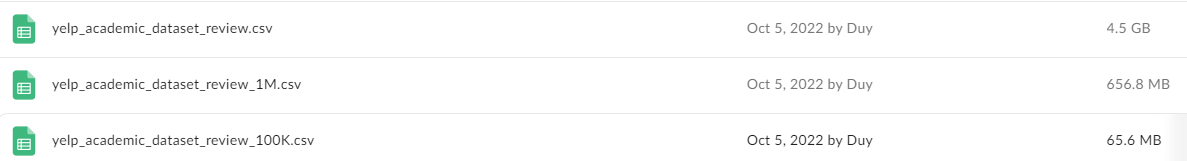

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install simplejson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 26.0 MB/s 


In [ ]:
# !python "/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp.json_to_csv_converter.py" "/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp_academic_dataset_review.json" 

/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp.json_to_csv_converter.py:54: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(v, collections.MutableMapping):


In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import Sequential
from keras.layers import Embedding, Conv1D,MaxPooling1D, Flatten, Dense,Dropout,LSTM,Bidirectional, CuDNNLSTM
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #
import scikitplot as skplt #


### Load Data

In case you want full file - Warning: it will take a long time
```python
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp_academic_dataset_review.csv') 
data_subset_df = data.sample(100000, random_state=5560)
data_subset_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp_academic_dataset_review_100K.csv', index = False)

```

In [ ]:
# data = pd.read_csv('review_star.csv')


data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSEE5590-KDM/Notebooks and Resources/Yelp/yelp_academic_dataset_review_100K.csv')

In [ ]:
data.head()

,review_id,user_id,cool,text,business_id,stars,date,funny,useful
0,b'Suur9K3VyARIJEdYNLlajg',b'K8D22KUbpfCxvK91lt5sxw',0,"b""I'm addicted! Love choosing my own toppings...",b'DU2KrvS9kBBV-HwzE2fQrA',5.0,b'2017-02-06 13:50:41',0,1
1,b'y3Fo8hd5KH7H63lX3T-zVA',b'XQpnAMe8uluv63TrDR5CgQ',0,"b""Our issue is something that unfortunately se...",b'1fy9fS3UH2k4TfQcryNKkA',1.0,b'2016-12-16 16:34:41',0,5
2,b'yTKU-LrQeThd7qldY3ZIiw',b'76_fiFy4Q3ao46WVSrKByg',0,b'All about the location. What a great spot. E...,b'Un-UDVOuv1co3TMmGaumxA',4.0,b'2018-05-05 21:25:49',0,0
3,b'ftrOgQ68B1dJvDDMIDcpIw',b'9p-deRHVfTM12virS2oP7w',0,"b""The staff was so nice. You can't find a pla...",b'5dtNc-kauiPwdrLNZbCqvg',2.0,b'2015-01-29 19:19:42',0,2
4,b'u7RW2ke8d0FUnooLbFcP8g',b'_A8HDRZBBWIB5d7zLtezbQ',0,b'We have Marcus and Amenda for our company Fa...,b'0IjDqJexP6jTH4F_Kg4mrQ',5.0,b'2012-08-21 20:54:03',0,0


In [ ]:
def simple_stars(stars): 
  if stars>3:
    return 1
  else:
    return 0

In [ ]:
data['stars_binary'] = data['stars'].map(simple_stars)

In [ ]:
data = data.dropna()
text = data['text'].tolist()
# binstars = data['stars'].tolist()
binstars = data['stars_binary'].tolist()

binstars = [int(star) for star in binstars]

### Make a balanced dataset of positive and negative review -- 50:50

In [ ]:
df_pos = data[data['stars_binary'] == 1].sample(25000, random_state = 5560)
df_neg = data[data['stars_binary'] == 0].sample(25000, random_state = 5560)
df_balanced = pd.concat([df_pos, df_neg]).reset_index(drop=True)
df_balanced.head()

,review_id,user_id,cool,text,business_id,stars,date,funny,useful,stars_binary
0,b'wQ_Ip4LnWSoYcbp5ssAYVw',b'miZaOsjF54onQ3nVzGT2tg',0,b'One of my favorite places for unique art wor...,b'3SM8CZuY5MiAruczCm556w',4.0,b'2019-07-12 14:21:19',0,0,1
1,b'ji6QoipmDXFcJA5SNy3m9Q',b'-Q8cGu_PGBYpxgI74P3dMw',1,b'Nice big dog park with a water fountain for ...,b'VU4jaQMZDJxKUihpnVM-LQ',4.0,b'2015-07-13 11:58:55',0,3,1
2,b'_7svfnTJe6xV0d95kSr1kw',b'2mpiMh7QBIMXvgKOLJ9v-w',1,"b""I called a few weeks earlier to make sure th...",b'h0tUOsL3sRYVqSQlxWjW5g',5.0,b'2021-12-21 19:14:32',0,1,1
3,b'Z79BpOb1owUVeHTXK1D18A',b'QaBNIUwzgN4v_5wjmlJOCg',3,"b'Most of what needs to be said has been said,...",b'U06ky7tOjrwad_zx05D9yQ',4.0,b'2009-11-07 20:32:06',1,2,1
4,b'XjVlLnXFwQk6kaz3bdPYDA',b'E4ghKoPlAGgm4C1oeQiFKQ',3,"b""I've taken my computer here twice. They do g...",b'IPOBDxV7Zj8RVKaTu7J4Jg',5.0,b'2014-09-12 05:05:33',0,16,1


In [ ]:
X = df_balanced['text'].values
y = df_balanced['stars_binary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5560)

In [ ]:
# cut reviews after 200 words
maxlen = 200 
# Number of words to consider as features
# restrict the yelp reviews to the top 10000 most common words
max_words = 10000  

In [ ]:
# create a tokenizer and it will ignore all except the 10000 most-common words
tokenizer = Tokenizer(num_words = max_words)
# use tokenizer to calculate the frequency of each word in dataset.
# tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X)

# convert all of reviews to lists of integers
# sequences = tokenizer.texts_to_sequences(balanced_texts)
# integer encode the documents
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)
print(encoded_train[0:2])

# use pad_sequence to make traning samples the same size, fill with zeros
# data_input = pad_sequences(sequences, maxlen = maxlen)
padded_train = pad_sequences(encoded_train, maxlen=maxlen)
padded_test = pad_sequences(encoded_test, maxlen=maxlen)

[[28, 803, 1, 104, 3173, 2373, 150, 2, 1, 1771, 24, 10, 1, 511, 11, 5, 1276, 9, 1, 97, 11, 117, 245, 490, 2, 121, 83, 89, 5, 136, 36, 30, 152, 196, 260, 1686, 4338, 489, 166, 15, 78, 4414], [28, 108, 7, 41, 131, 22, 4, 794, 29, 33, 2, 22, 258, 81, 127, 272, 343, 395, 41, 14, 85, 6, 132, 332, 1244, 272, 343, 2, 794, 158, 4591, 340, 34, 131, 53, 14, 462, 421, 1, 343, 8, 130, 254, 45, 272, 343, 2, 8, 227, 220, 27, 41, 8, 6, 905, 587, 1369, 45, 15, 1011, 272, 343, 2, 441, 8, 10, 1, 2304, 2062, 321, 561, 343, 654, 13, 343, 350, 45, 8, 6, 122, 1176, 2, 6, 44, 266, 10, 1, 2383, 13, 6, 21, 272, 343, 8, 6, 4356, 56, 343, 16, 1072, 78, 8, 6, 12, 108, 2, 74, 46, 47, 3, 483, 1, 292, 2, 54, 1437, 333, 395, 44, 1393, 39, 54, 11, 4, 8127, 1350, 1, 1560, 333, 403, 3, 171, 15, 446, 1, 1437, 333, 5, 1034, 26, 15, 113, 23, 5, 327, 35, 115, 9, 4463, 537, 90, 61, 47, 3, 258, 144, 5, 175, 19, 33, 438]]


 ### Model 1 - Using Embedding layer and LSTM

My first model consisted of an embedding layer, a LSTM layer and the output from LSTM was fed into a hidden fully connected layer. This layer has an output size of 1, meaning it will always output 1 or 0, 1 for positive reviews and 0 for negative ones.

The requirements to use the cuDNN implementation are:
```python
activation == tanh
recurrent_activation == sigmoid
recurrent_dropout == 0
unroll is False
use_bias is True
Inputs, if use masking, are strictly right-padded.
Eager execution is enabled in the outermost context.
```

In [ ]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(padded_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 6s 17ms/step - loss: 0.3806 - acc: 0.8316 - val_loss: 0.2839 - val_acc: 0.8945
Epoch 2/5
250/250 [==============================] - 4s 15ms/step - loss: 0.2507 - acc: 0.9034 - val_loss: 0.2759 - val_acc: 0.8932
Epoch 3/5
250/250 [==============================] - 4s 15ms/step - loss: 0.2180 - acc: 0.9166 - val_loss: 0.2995 - val_acc: 0.8874
Epoch 4/5
250/250 [==============================] - 4s 15ms/step - loss: 0.1987 - acc: 0.9251 - val_loss: 0.2809 - val_acc: 0.8925
Epoch 5/5
250/250 [==============================] - 5s 21ms/step - loss: 0.1845 - acc: 0.9305 - val_loss: 0.2663 - val_acc: 0.8917


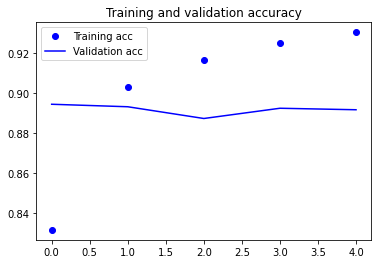

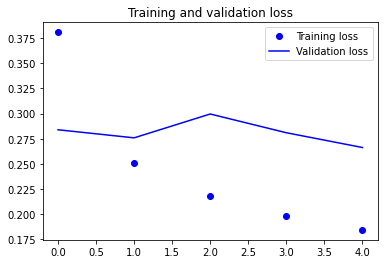

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(padded_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.2647 - acc: 0.8953


[0.2646532654762268, 0.8952999711036682]

In [ ]:
predictions = {}
y_preds = (model.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_LSTM = accuracy_score(y_test, y_preds)

predictions['LSTM_Only'] = accuracy_LSTM * 100


[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


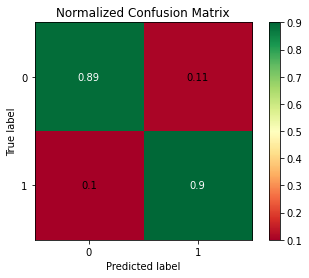

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, y_preds, normalize = True, cmap = 'RdYlGn')

This paper (https://arxiv.org/pdf/1903.07288.pdf) studied the effect of padding types on LSTM and CNN. They found that post-padding achieved substantially lower accuracy (nearly half) compared to pre-padding in LSTMs, although there wasn't a significant difference for CNNs (post-padding was only slightly worse).

A simple/intuitive explanation for RNNs is that, post-padding seems to add noise to what has been learned from the sequence through time, and there aren't more timesteps for the RNN to recover from this noise. With pre-padding, however, the RNN is better able to adjust to the added noise of zeros at the beginning as it learns from the sequence through time.

 ### Model 2 -  Using combination of CNN and RNN

 For my second model, I used combination of recurrent neural network with LSTM and convolutional neural network. I had a dropout layer right after embedding layer and added a convolutional layer, a max pooling layer.


In [ ]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 128, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(LSTM(64))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_conv.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout_4 (Dropout)         (None, 200, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 196, 64)           41024     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 65, 64)           0         
 1D)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
history = model_conv.fit(padded_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 5s 14ms/step - loss: 0.3495 - acc: 0.8418 - val_loss: 0.2581 - val_acc: 0.8996
Epoch 2/5
250/250 [==============================] - 3s 12ms/step - loss: 0.2012 - acc: 0.9222 - val_loss: 0.2712 - val_acc: 0.8891
Epoch 3/5
250/250 [==============================] - 3s 12ms/step - loss: 0.1478 - acc: 0.9453 - val_loss: 0.2820 - val_acc: 0.8914
Epoch 4/5
250/250 [==============================] - 3s 13ms/step - loss: 0.1035 - acc: 0.9647 - val_loss: 0.3270 - val_acc: 0.8881
Epoch 5/5
250/250 [==============================] - 4s 16ms/step - loss: 0.0682 - acc: 0.9772 - val_loss: 0.4023 - val_acc: 0.8829


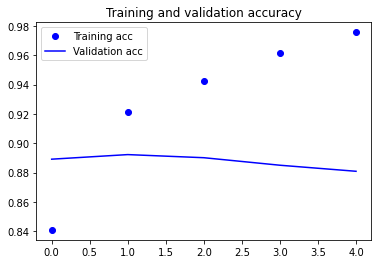

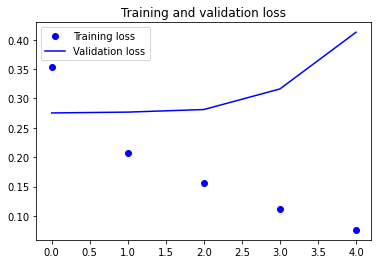

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model_conv.evaluate(padded_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4031 - acc: 0.8828


[0.40305987000465393, 0.8827999830245972]

In [ ]:
y_preds = (model_conv.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_LSTM_CNN = accuracy_score(y_test, y_preds)

predictions['LSTM_CNN'] = accuracy_LSTM_CNN * 100

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


Compare this with model using a LSTM layer only, the accuracy was lower, 89.592% vs 88.28%. The model was overfitting after one epoch. However, adding a convolutional layer did speed up the training

CNN overfits the training data fairly quickly, leading to lower performance in validation/test data.

#Assignment #1:  Use bidirectional RNNs
Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

* Wrap the `Bidirectional` Layer around the `LSTM` layer to create a BiLSTM layer
* Train and report accuracy

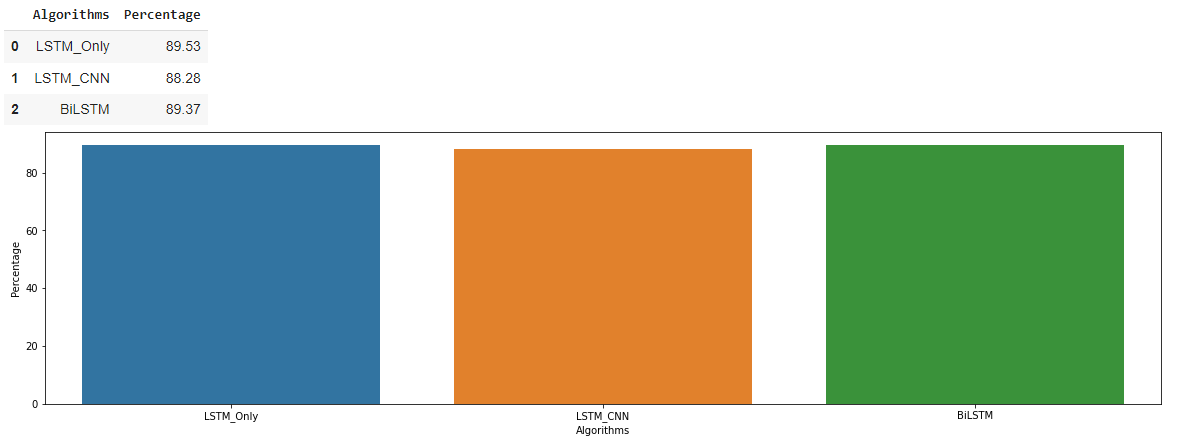


In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
#Define and Compile your model architecture here
...
...
...

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train your model here
history = model.fit(...)

Epoch 1/5
250/250 [==============================] - 12s 38ms/step - loss: 0.3640 - acc: 0.8457 - val_loss: 0.2801 - val_acc: 0.8930
Epoch 2/5
250/250 [==============================] - 6s 26ms/step - loss: 0.2482 - acc: 0.9048 - val_loss: 0.2751 - val_acc: 0.8851
Epoch 3/5
250/250 [==============================] - 7s 27ms/step - loss: 0.2125 - acc: 0.9193 - val_loss: 0.2660 - val_acc: 0.8954
Epoch 4/5
250/250 [==============================] - 7s 26ms/step - loss: 0.1931 - acc: 0.9265 - val_loss: 0.2624 - val_acc: 0.8959
Epoch 5/5
250/250 [==============================] - 7s 26ms/step - loss: 0.1737 - acc: 0.9346 - val_loss: 0.2823 - val_acc: 0.8944


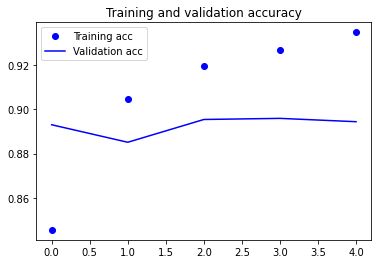

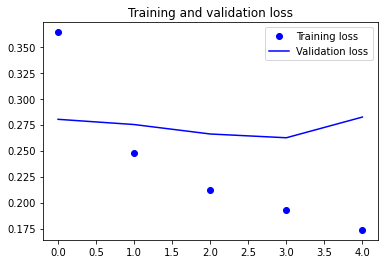

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(...)

313/313 [==============================] - 5s 14ms/step - loss: 0.2758 - acc: 0.8937


[0.2758282721042633, 0.8937000036239624]

In [ ]:
y_preds = (model.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_BiLSTM = accuracy_score(y_test, y_preds)

predictions['BiLSTM'] = accuracy_BiLSTM * 100

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


,Algorithms,Percentage
0,LSTM_Only,89.53
1,LSTM_CNN,88.28
2,BiLSTM,89.37


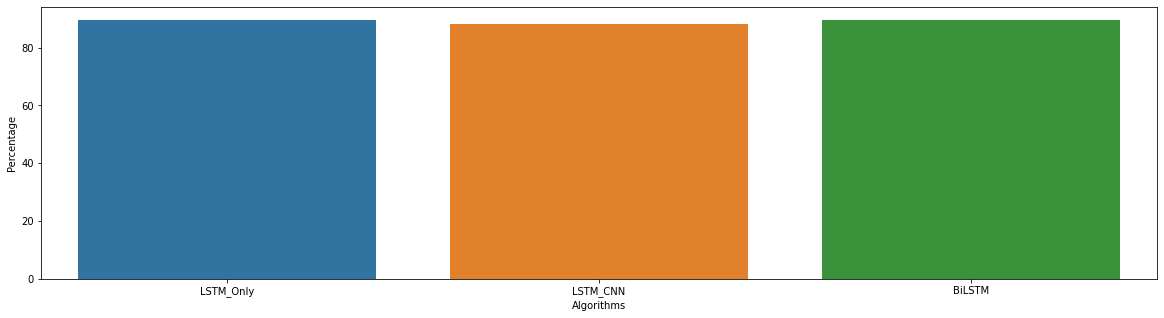

In [ ]:
import seaborn as sns
fig, (ax1) = plt.subplots(ncols = 1, sharey = True,figsize = (20,5))
df = pd.DataFrame(list(predictions.items()),columns = ['Algorithms','Percentage'])
display(df)
sns.barplot(x = "Algorithms", y = "Percentage", data = df,ax = ax1);

# Assignment #2: Use original labels instead of binary labels.

* Use `stars` instead of `stars_binary` for classification and report accuracy.
* Use another version of the dataset (`1M.csv` or full dataset).